In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir
import ast
# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
ncore

256

# Workflow starts here!

In [9]:
###################### need to change start
ipts="32340"
###################### need to change end

In [3]:
# hdf5_loc = "/netdisk/y9z/IPTS-"+ipts+"/hdf5/"
hdf5_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
sorted(os.listdir(hdf5_loc))

['2024_01_29_stack1.h5',
 '2024_01_30.h5',
 '2024_03_17_laminography_S1_lamino_735proj_gridrec.h5',
 '2024_03_17_laminography_S1_lamino_735proj_gridrec_test.h5',
 '2024_03_17_laminography_S2_lamino_735proj_gridrec.h5',
 '2024_03_17_laminography_S2_lamino_735proj_gridrec_test.h5',
 '2024_04_09_lam_S3_lami_924proj_gridrec.h5',
 '2024_04_09_lam_S3_lami_924proj_gridrec_test.h5',
 '2024_04_09_lam_S3_lamino_924proj_gridrec.h5',
 '_rec']

In [4]:
###################### need to change start
sample_name = "2024_03_17_laminography_S1_lamino_735proj_gridrec"
hdf5 = hdf5_loc + sample_name + ".h5"
###################### need to change end

# Load hdf5 file

In [5]:
losa.get_hdf_tree(hdf5)
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
history_dict

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (735,)
    │   ├── ang_rad (735,)
    │   ├── fname (735,)
    │   ├── proj000_idx (1,)
    │   ├── proj180_idx (1,)
    │   └── proj360_idx (1,)
    ├── proj
    │   │
    │   ├── proj_mlog_pre_ring (735, 1100, 1846)
    │   ├── proj_mlog_pre_tilt (735, 1873, 1847)
    │   ├── proj_mlog_to_recon (735, 1100, 1846)
    │   └── proj_norm_pre_tilt (735, 1873, 1847)
    ├── raw_ref
    │   │
    │   ├── dc_max (2048, 2048)
    │   ├── fluc_corr_roi_min (472, 600)
    │   ├── ob_min (2048, 2048)
    │   ├── proj_crop_roi_min (1873, 1847)
    │   └── proj_min (2048, 2048)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (1100, 1846, 1846)
    └── sino
        │
        ├── sino_mlog_pre_ring (1100, 735, 1846)
        ├── sino_mlog_pre_tilt (1873, 735, 1847)
        └── sino_mlog_to_recon (1100, 735, 1846)


{'crop': True,
 'crop_roi_dict': {'left': 200, 'right': -1, 'top': 65, 'bottom': -110},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'pixel_bin_size': 1,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi_dict': {'left': 0,
  'right': 600,
  'top': 1400,
  'bottom': -1},
 'minus_log': True,
 'tilt_corr_used': 'neutompy',
 'rot_center_180': 917.5,
 'rot_center_360': 920.5,
 'rot_center': 920.5,
 'tilt_corr_theta': -0.42852977087061767,
 'tilt_corr_shift': -13,
 'ring_rmv_roi': True,
 'ring_rmv_roi_dict': {'left': 0, 'right': -1, 'top': 0, 'bottom': 1100},
 'ring_removal': 'bm3dgpu',
 'pixel_size_um': 42,
 'recon_unit': 'cm-1',
 'start_ang_idx': 0,
 'end_ang_idx': 733,
 'recon_algo': 'gridrec',
 'recon_crop': False}

In [6]:
proj_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/proj/proj_mlog_to_recon')
# sino_mlog = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog')
sino_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog_to_recon')
ang_deg = losa.load_hdf(hdf5, key_path='tomo/info/ang_deg')
ang_rad = losa.load_hdf(hdf5, key_path='tomo/info/ang_rad')
proj000_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj000_idx')[0]
proj180_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj180_idx')[0]
proj360_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj360_idx')[0]
rot_center_used = history_dict['rot_center']
rot_center_180 = history_dict['rot_center_180']
rot_center_360 = history_dict['rot_center_360']
pixel_size_um = history_dict['pixel_size_um']
# recon_hdf5 = losa.load_hdf(hdf5, key_path='tomo/recon/recon_volume')
gamma_diff = 20
# sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)
if history_dict['recon_crop']:
    recon_crop = True
    recon_crop_left = history_dict['recon_crop_roi']['left']
    recon_crop_right = history_dict['recon_crop_roi']['right']
    recon_crop_top = history_dict['recon_crop_roi']['top']
    recon_crop_bottom = history_dict['recon_crop_roi']['bottom']
else:
    recon_crop = False
    recon_crop_left = None
    recon_crop_right = None
    recon_crop_top = None
    recon_crop_bottom = None

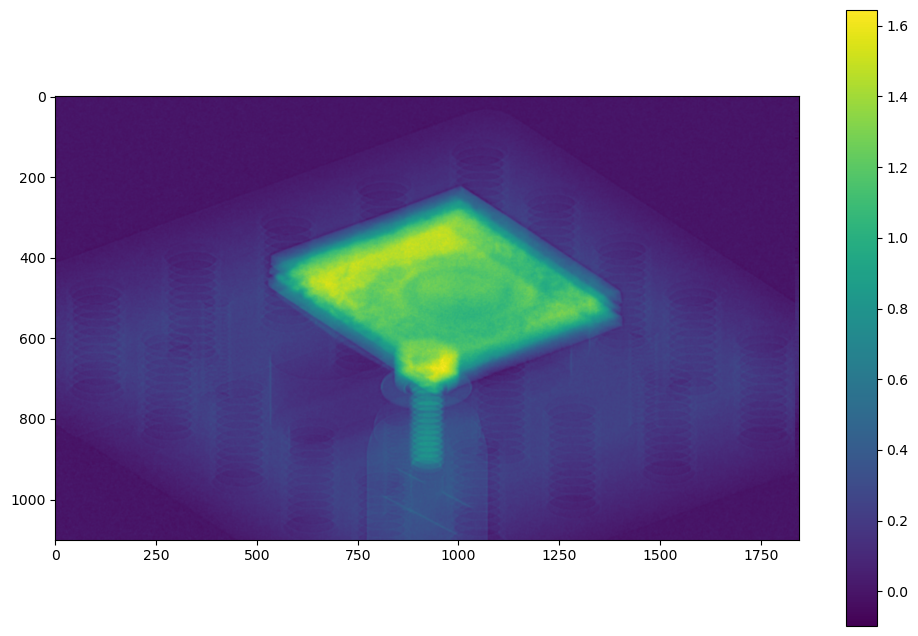

In [11]:
###################### need to change start
idx = 100
###################### need to change end
plt.imshow(proj_mlog_to_recon[idx])
plt.colorbar()
plt.show()

In [16]:
from tomocupy_stream import GPURecRAM
import time

In [39]:
proj_shape = proj_mlog_to_recon.shape
dark_fake = np.zeros((1, proj_shape[1], proj_shape[2]), dtype=np.float32)
flat_fake = np.ones((1, proj_shape[1], proj_shape[2]), dtype=np.float32)

In [41]:
cl = GPURecRAM.for_data_like(
    data=sino_mlog_to_recon,
    dark=dark_fake,
    flat=flat_fake,
    ncz=12,  # chunk size (multiple of 2)
    dtype="float32",  # computation type, note  for float16 n should be a power of 2
    reconstruction_algorithm = 'linerec',  # fourierrec, lprec, or linerec

    dezinger = 0, # zinger size (0 - no zingers)
    # dezinger = 2, # removing Zingers
    # dezinger_threshold = 5000,
    
    remove_stripe_method = 'None',
    # remove_stripe_method = 'fw',
    # fw_sigma = 1,
    # fw_level = 7,
    # fw_filter = 'sym16',

    # remove_stripe_method = 'ti',
    # ti_beta = 0.022,
    # ti_mask = 1.0,
    # remove_stripe_method = 'vo-all',
    # vo_all_snr=3,
    # vo_all_la_size=61,
    # vo_all_sm_size=21,
    # vo_all_dim=1,

    fbp_filter = 'parzen',  # filter for fbp
    rotation_axis = rot_center_used, # rotation center
    minus_log=False,
)

In [42]:
t = time.time()
result = cl.recon_all(data=sino_mlog_to_recon, dark=dark_fake, flat=flat_fake, theta=ang_deg)
print(f"Reconstruction time: {time.time()-t}s")

AttributeError: module 'cupy' has no attribute 'float'

In [ ]:
def data_loader(data, ):
    n=data.shape[2],
    nz=data.shape[0],
    nproj=data.shape[1],
    ncz=ncz,
    ndark=dark.shape[0],
    nflat=flat.shape[0],
    in_dtype=data.dtype,
    dtype=dtype,
    rotation_axis=rotation_axis,
    reconstruction_algorithm=reconstruction_algorithm,
    remove_stripe_method=remove_stripe_method,
    fw_sigma=fw_sigma,
    fw_filter=fw_filter,
    fw_level=fw_level,
    ti_beta=ti_beta,
    ti_mask=ti_mask,
    vo_all_snr=vo_all_snr,
    vo_all_la_size=vo_all_lÒa_size,
    vo_all_sm_size=vo_all_sm_size,
    vo_all_dim=vo_all_dim,
    dezinger=dezinger,
    dezinger_threshold=dezinger_threshold,
    fbp_filter=fbp_filter,
    minus_log=minus_log
    

In [ ]:
cl = GPURecRAM(
    n = n,
    nz = nz,
    nproj = nproj,
    ncz = 8,  # chunk size (multiple of 2)
    ndark = ndark,
    nflat = nflat,
    in_dtype = in_dtype,
    dtype = 'float32',  # computation type, note  for float16 n should be a power of 2
    reconstruction_algorithm = 'fourierrec',  # fourierrec, lprec, or linerec

    dezinger = 0, # zinger size (0 - no zingers)
    # dezinger = 2, # removing Zingers
    # dezinger_threshold = 5000,
    
    remove_stripe_method = 'None',
    # remove_stripe_method = 'fw',
    # fw_sigma = 1,
    # fw_level = 7,
    # fw_filter = 'sym16',

    # remove_stripe_method = 'ti',
    # ti_beta = 0.022,
    # ti_mask = 1.0,
    # remove_stripe_method = 'vo-all',
    # vo_all_snr=3,
    # vo_all_la_size=61,
    # vo_all_sm_size=21,
    # vo_all_dim=1,

    fbp_filter = 'parzen',  # filter for fbp
    rotation_axis = rotation_axis, # rotation center
    minus_log=True
)
# run recon
t = time.time()
cl.recon_all(data, dark, flat, theta, output=result)
print(f'Reconstruction time: {time.time()-t}s')

In [ ]:
cl = GPURecRAM(
    n=1536,  # sample size in x
    nz=22,  # sample size in z
    nproj=720,  # number of projection angles
    ncz=8,  # chunk size (multiple of 2)
    ndark=10,  # number of dark fields
    nflat=20,  # number of flat fields
    in_dtype='uint16',  # input data type
    dtype='float32',  # computation type, note  for float16 n should be a power of 2
    reconstruction_algorithm='fourierrec',  # fourierrec, lprec, or linerec

    dezinger=0,  # zinger size (0 - no zingers)
    # dezinger = 2,  # removing Zingers
    # dezinger_threshold = 5000,

    remove_stripe_method='None',
    # remove_stripe_method = 'fw',
    # fw_sigma = 1,
    # fw_level = 7,
    # fw_filter = 'sym16',

    # remove_stripe_method = 'ti',
    # ti_beta = 0.022,
    # ti_mask = 1.0,
    # remove_stripe_method = 'vo-all',
    # vo_all_snr=3,
    # vo_all_la_size=61,
    # vo_all_sm_size=21,
    # vo_all_dim=1,

    fbp_filter='parzen',  # filter for fbp
    rotation_axis=rotation_axis,  # rotation center
    minus_log=True
)

# run recon
result = cl.recon_all(data, dark, flat, theta)

In [ ]:
def for_data_like(
        cls,
        *,
        data,
        dark,
        flat,
        ncz,
        dtype,
        rotation_axis,
        reconstruction_algorithm="fourierrec",
        remove_stripe_method="None",
        fw_sigma=None,
        fw_filter=None,
        fw_level=None,
        ti_beta=None,
        ti_mask=None,
        vo_all_snr=None,
        vo_all_la_size=None,
        vo_all_sm_size=None,
        vo_all_dim=None,
        dezinger=0,
        dezinger_threshold=5000,
        fbp_filter="parzen",
        minus_log=True
    ):
        """
        Construct a GPURecRAM instance from sample data.
        """
        return cls(
            n=data.shape[2],
            nz=data.shape[0],
            nproj=data.shape[1],
            ncz=ncz,
            ndark=dark.shape[0],
            nflat=flat.shape[0],
            in_dtype=data.dtype,
            dtype=dtype,
            rotation_axis=rotation_axis,
            reconstruction_algorithm=reconstruction_algorithm,
            remove_stripe_method=remove_stripe_method,
            fw_sigma=fw_sigma,
            fw_filter=fw_filter,
            fw_level=fw_level,
            ti_beta=ti_beta,
            ti_mask=ti_mask,
            vo_all_snr=vo_all_snr,
            vo_all_la_size=vo_all_la_size,
            vo_all_sm_size=vo_all_sm_size,
            vo_all_dim=vo_all_dim,
            dezinger=dezinger,
            dezinger_threshold=dezinger_threshold,
            fbp_filter=fbp_filter,
            minus_log=minus_log
        )

In [ ]:
# Tilt correction (neutompy)
_proj_mlog = proj_mlog_to_recon[:]
proj_mlog_tilt = correction_COR(norm_proj=_proj_mlog, proj_0=_proj_mlog[proj000_idx], proj_180=_proj_mlog[proj180_idx],
                               # shift=-15, theta=0.034688876524931536
                               )
# tt_ang = 'neutompy'
# history_dict = rocku.log(history_dict, 'tilt_corr_use', 'neutompy')

# Reconstruction

In [8]:
pix_um = pixel_size_um # um

# recon_algo = 'gridrec'
recon_algo = 'SIRT_CUDA'
# recon_algo = 'svmbir'

full_360 = True
# full_360 = False
##################################
slice_by_slice = False
if full_360:
    start_ang_idx = proj000_idx
    end_ang_idx = proj360_idx
    rot_center = rot_center_360
else:
    start_ang_idx = proj000_idx
    end_ang_idx = proj180_idx
    rot_center = rot_center_180
t0 = timeit.default_timer()
####################### tomopy algorithms (gridrec and fbp are faster than algotom) ##########################
if recon_algo in ['art', 'bart', 'fbp', 'gridrec',
                  'mlem', 'osem', 'ospml_hybrid', 'ospml_quad',
                  'pml_hybrid', 'pml_quad', 'sirt', 'tv', 'grad', 'tikh']:
    recon = tomopy.recon(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], ang_rad[start_ang_idx:end_ang_idx], center=rot_center,
                         algorithm=recon_algo,
                         ncore=ncore, 
#                          nchunk=nchunk
                        )
################################################ algotom algorithms ##########################################
    #### ASTRA
if recon_algo in ['FBP', 'SIRT', 'SART', 'ART', 'CGLS', 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', 'CGLS_CUDA']:
    recon = rec.astra_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], 
                                     rot_center, 
                                     angles=ang_rad[start_ang_idx:end_ang_idx],
                                     apply_log=False,
                                     method=recon_algo,
                                     ratio=1.0,
                                     filter_name='hann',
                                     pad=None,
                                     num_iter=300,
                                     ncore=ncore
                                    )
    recon = np.moveaxis(recon, 1, 0) 
    #### gridrec from algotom
if recon_algo == 'gridrec_algo':
    recon = rec.gridrec_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:],
                                       rot_center, 
                                       angles=ang_rad[start_ang_idx:end_ang_idx], 
                                       apply_log=False,
                                       ratio=1.0,
                                       filter_name='shepp',
                                       pad=100,
                                       ncore=ncore
                                      )
    recon = np.moveaxis(recon, 1, 0)
    #### FBP from algotom
if recon_algo == 'fbp_algo':
    recon = rec.fbp_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], 
                                   rot_center, 
                                   angles=ang_rad[start_ang_idx:end_ang_idx], 
                                   apply_log=False,
                                   ramp_win=None,
                                   filter_name='hann',
                                   pad=None,
                                   pad_mode='edge',
                                   ncore=ncore,
                                   gpu=False,
#                                   gpu=True, block=(16, 16), # Version error 7.8, current version 7.5
                                  )
    recon = np.moveaxis(recon, 1, 0)
################################################### MBIR #####################################################
if recon_algo == 'svmbir':
    T = 2.0
    p = 1.2
    sharpness = 0.0
    snr_db = 30.0
    center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
    recon = svmbir.recon(
        proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:],
#         proj_mlog_to_recon[:,595:605,:],
        angles=np.array(ang_rad)[start_ang_idx:end_ang_idx], # In radians
        weight_type='transmission', 
        center_offset=center_offset, 
        snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
        positivity=False,
        max_iterations=50,
        num_threads= 112,
        verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
        svmbir_lib_path = svmbir_path,
    )
    recon = np.fliplr(np.rot90(recon, k=1, axes=(1,2)))
##################################
if pix_um is not None:
    pix_cm = pix_um/10000
    recon = recon/pix_cm
    history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)
    history_dict = rocku.log(history_dict, 'recon_unit', 'cm-1')
    recon_unit = 'cm-1'
else:
    history_dict = rocku.log(history_dict, 'recon_unit', 'px-1')
    recon_unit = 'px-1'
# history_dict = rocku.log(history_dict, 'start_ang_idx', start_ang_idx)
# history_dict = rocku.log(history_dict, 'end_ang_idx', end_ang_idx)
# history_dict = rocku.log(history_dict, 'rot_center', rot_center)
# history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)
t1 = timeit.default_timer()
print("Time cost {} min".format(round((t1-t0)/60), 2))

Time cost 107 min


# Export recon files

In [9]:
################ change save path for your own
# Apply cropping to the whole recon volume and save info to h5
recon = rocku.crop(recon, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
num_proj = len(ang_rad)
_split = sample_name.split('_')
_split.pop(-1)
_sample_name = '_'.join(_split)
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name + "_all"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + _sample_name + '_' + recon_algo
# save_to = "/netdisk/y9z/IPTS-"+ipts+"/recon/" + sample_name
print(save_to)
dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

/HFIR/CG1D/IPTS-32484/shared/processed_data/rockit/2024_10_28_CT_655proj_SIRT_CUDA


In [ ]:
# # save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name + "_redo"
# save_to = "/netdisk/y9z/IPTS-"+ipts+"/recon/" + sample_name + "_redo"
# pix_um = history_dict['pixel_size_um']
# pix_cm = pix_um/10000
# t0 = timeit.default_timer()
# recon_algo = 'gridrec'
# for h_idx in range(sino_mlog_to_recon.shape[0]):
#     _rec_slice = rec.gridrec_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False)
#     _rec_slice = rocku.crop(_rec_slice, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
#     _rec_slice_cm = _rec_slice/pix_cm
#     _slice_name = save_to + "/recon_" + f'{h_idx:04d}'
#     print('Saving {} ...'.format(_slice_name))
#     dxchange.write_tiff(_rec_slice_cm, fname=_slice_name, overwrite=True)
# t1 = timeit.default_timer()
# print("Time cost {} min".format((t1-t0)/60))
# # history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)